# About
This notebook shows an example of how to predict SLR using a random forest ML model at individual HRRR grid points or across the HRRR's full domain.

# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import xarray as xr
import matplotlib.pyplot as plt
import sys
import cartopy.crs as ccrs
import time

sys.path.append('../scripts/')
import hrrr_funcs, slr_grid_funcs

sys.path.append('../scripts/plotting_scripts/')
import maps

from scipy.spatial import KDTree
from cartopy.io.img_tiles import GoogleTiles

# Globals

In [2]:
# Contour levels and colors for SLR
SLR_INTV_LEVS = [
    2,
    4,
    6,
    8,
    10,
    12,
    14,
    16,
    18,
    20
]

SNOW_INTV_LEVS_CM_6H = [
    1,
    2,
    3,
    4,
    5,
    7.5,
    10,
    15,
    20,
    25
]

SNOW_INTV_LEVS_CM_1H = [
    0.1,
    0.5,
    1,
    1.5,
    2,
    2.5,
    3,
    3.5,
    4,
    5
]


SLR_FILL_COLORS = [
    '#348FC2',
    '#62B7AD',
    '#98DD94',
    '#DBFA7E',
    '#E7DF47',
    '#DFAB32',
    '#D47732',
    '#C54531',
    '#B62C31',
    '#950002'
]

# Subplots adjustments based on region
SUBPLOTS_ADJUST = {
    'WE': (0.958, 0.025, 0.035, 0.975, 0.061, 0.023),
    'CO': (0.925, 0.025, 0.2, 0.965, 0.061, 0.023),
    'WF': (0.9, 0.215, 0.225, 0.92, 0.061, 0.023),
    'NU': (0.925, 0.025, 0.18, 0.965, 0.061, 0.023),
    'NW': (0.945, 0.03, 0.12, 0.98, 0.061, 0.023),
    'SN': (0.905, 0.085, 0.2, 0.965, 0.061, 0.023),
    'SW': (0.925, 0.025, 0.145, 0.96, 0.061, 0.023),
    'IM': (0.925, 0.025, 0.175, 0.965, 0.061, 0.023),
    'CE': (0.953, 0.025, 0.04, 0.975, 0.061, 0.023),
    'EA': (0.953, 0.025, 0.04, 0.975, 0.061, 0.023),
    'GL': (0.87, 0.09, 0.15, 0.96, 0.061, 0.023),
    'NE': (0.925, 0.025, 0.165, 0.96, 0.061, 0.023),
    'NE_CASE': (0.925, 0.025, 0.165, 0.96, 0.061, 0.023),
    'MA': (0.91, 0.065, 0.145, 0.96, 0.061, 0.023)
}

# Colorbar positioning based on region
CB_POS = {
    'WE': (0.175, 0.0725),
    'CO': (0.9875, 0.145),
    'WF': (0.945, 0.215),
    'NU': (0.99, 0.145),
    'NW': (1, 0.15),
    'SN': (0.9875, 0.15),
    'SW': (0.9775, 0.145),
    'IM': (0.985, 0.145),
    'CE': (1, 0.15),
    'EA': (0.17, 0.175),
    'GL': (0.98, 0.15),
    'NE': (0.17, 0.1525),
    'NE_CASE': (0.165, 0.16),
    'MA': (0.98, 0.14)
}

# Lat/lon bounds for each region
MAP_REGIONS = {
    'WE': (-126, -103.25, 31, 49.5),
    'CO': (-110, -104, 36.8, 41.1),
    'WF': (-114.0,-111.0,40.0,41.75),
    'NU': (-115.5,-108.5,38.5,43.25),
    'NW': (-130,-113,40,50),
    'SN': (-123.5, -116.0, 35., 40),
    'SW': (-127,-107,29,43),
    'IM': (-122,-106,34,45),
    'CE': (-112.75,-81.25,31,49.5),
    'EA': (-104,-66.,31,49.5),
    'GL': (-94,-73,37.5,49),
    'NE': (-82,-66,39,48),
    'NE_CASE': (-78.25, -68, 40.25, 46), # original is (-79, -68, 40, 47)
    'MA': (-85,-71,33,42)
}

# Read in HRRR sample data

In [3]:
sampledir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mpletcher/SLR_CONUS/data/hrrr/sample_orog/'
datadir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mpletcher/SLR_CONUS/data/hrrr/raw_grids/cases/20230315/'
yr, mn, dy, hr, fhr = 2023, 3, 14, 12, 10
init_time = pd.Timestamp(int(yr), int(mn), int(dy), int(hr))
valid_time = pd.Timestamp(int(yr), int(mn), int(dy), int(hr), int(fhr))
f = datadir + init_time.strftime('%Y%m%d%H') + 'F' + str(fhr).zfill(2) + 'hrrr.grib2'
display(f)

ds = hrrr_funcs.load_all_hrrr_vars(
    datadir,
    init_time,
    fhr
)

# Postprocess HRRR data to calculate 
# wind speed
ds = hrrr_funcs.calc_needed_vars(ds)
ds

'/uufs/chpc.utah.edu/common/home/steenburgh-group10/mpletcher/SLR_CONUS/data/hrrr/raw_grids/cases/20230315/2023031412F10hrrr.grib2'

<xarray.Dataset>
Dimensions:            (isobaricInhPa: 40, y: 1059, x: 1799)
Coordinates:
    time               datetime64[ns] ...
  * isobaricInhPa      (isobaricInhPa) float64 1.013e+03 1e+03 ... 75.0 50.0
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 -122.7 -122.7 -122.7 ... -60.95 -60.92
    valid_time         datetime64[ns] ...
    step               timedelta64[ns] ...
    surface            float64 ...
    heightAboveGround  float64 ...
    meanSea            float64 ...
Dimensions without coordinates: y, x
Data variables: (12/18)
    t                  (isobaricInhPa, y, x) float32 ...
    u                  (isobaricInhPa, y, x) float32 -1.883 -1.82 ... 6.281
    v                  (isobaricInhPa, y, x) float32 -1.702 -1.702 ... 3.776
    q                  (isobaricInhPa, y, x) float32 ...
    w                  (isobaricInhPa, y, x) float32 ...
    r                  (isobaricInhPa, y, x) float32 ...
    ...                 ...
    v10                (y, x) float32 ...
    orog               (y, x) float32 ...
    mslma              (y, x) float32 ...
    sp                 (y, x) float32 ...
    spd                (isobaricInhPa, y, x) float32 2.538 2.492 ... 7.297 7.329
    p                  (isobaricInhPa, y, x) float64 1.013e+03 ... 50.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-05-30T15:13 GRIB to CDM+CF via cfgrib-0.9.1...

# Read in 6-h NOHRSC data for selected case

In [4]:
ds_nohrsc = xr.open_dataset(
    '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mpletcher/SLR_CONUS/data/nohrsc/20230315_1200_case/nohrsc_CONUS_6h_2023031500.nc'
).rename({'Data' : 'snowfall'})
ds_nohrsc = ds_nohrsc.drop_dims('nv')
ds_nohrsc['snowfall'].load()
ds_nohrsc['snowfall'] = ds_nohrsc['snowfall'] * 100 # Convert from m to cm
ds_nohrsc

<xarray.Dataset>
Dimensions:   (lat: 850, lon: 1500)
Coordinates:
  * lat       (lat) float64 54.98 54.94 54.9 54.86 ... 21.14 21.1 21.06 21.02
  * lon       (lon) float64 -126.0 -125.9 -125.9 -125.9 ... -66.1 -66.06 -66.02
Data variables:
    crs       int16 ...
    snowfall  (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    format_version:  NOHRSC NetCDF raster file v1.2
    Conventions:     CF-1.6
    title:           The National Snowfall Analysis, Version 2.1, is based on...
    source:          surface observations of snowfall; Stage IV QPE; HRRR; GH...
    history:         2023-03-17 01:39:03 UTC created by module: sfav2.pro
    comment:         2023-03-17 01:39:03 UTC created comment: sfav2.pro writt...
    references:      Not applicable

# Plot NOHRSC data and locate active areas

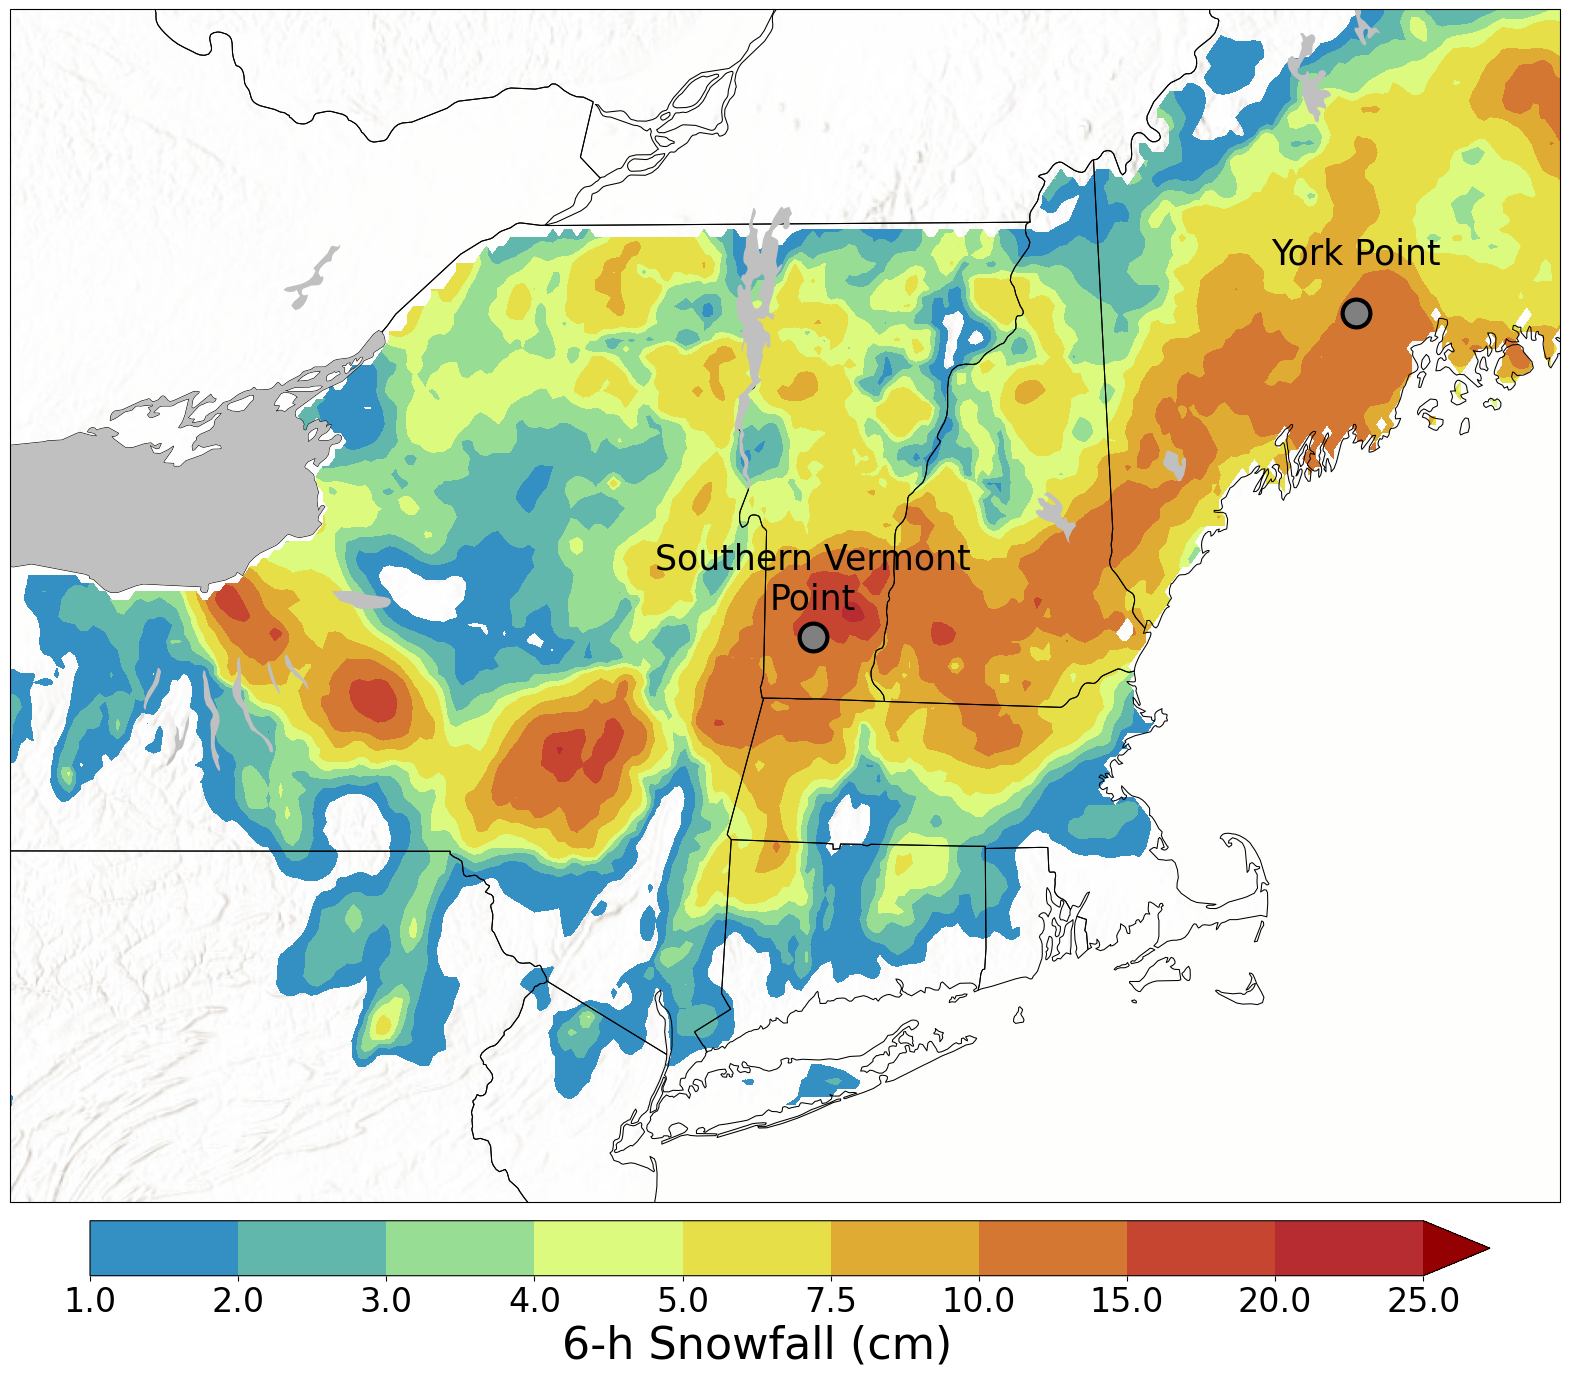

In [5]:
# Set region
REGION = 'NE_CASE'
CB_X, CB_Y = CB_POS[REGION]

# Create figure
fig, ax = maps.conus_map(topo_overlay = True, map_detail = 7)
ax.set_extent(MAP_REGIONS[REGION])

# Plot 6-h snowfall analysis
ct = ax.contourf(
    ds_nohrsc.lon,
    ds_nohrsc.lat,
    ds_nohrsc.snowfall.values,
    transform = ccrs.PlateCarree(),
    levels = SNOW_INTV_LEVS_CM_6H,
    zorder = 1,
    colors = SLR_FILL_COLORS,
    extend = 'max'
)

# Colorbar setup
cbar_ax = fig.add_axes([CB_X, CB_Y, 0.7, 0.0275])
cb = fig.colorbar(
    ct, 
    cax = cbar_ax, 
    fraction = 0.046, 
    pad = 0.04, 
    orientation = 'horizontal', 
    extend = 'max'
)
cb.set_label('6-h Snowfall (cm)', size = 32)
cb.ax.tick_params(labelsize = 24)

# Plot locations of high snowfall total areas
# Points (in order) are: southern Vermont, northeast 
# New York, and coastal southeast Maine
lats = [
    43.042510, # southern Vermont
    44.586555, # south-central Maine
    42.458632 # south-central New York
]
lons = [
    -72.9422, # southern Vermont
    -69.351196, # south-central Maine
    -74.40933 # south-central New York
]
names = [
    'Southern Vermont\nPoint',
    'York Point'
]

#plt.text(-110.922451 + 2.4, 45.829109 + 1.1, 'BBL', fontsize = 37.5, color = 'k', transform = ccrs.PlateCarree(), ha = 'center', va = 'center', zorder = 11)

for lat, lon, name in zip(lats, lons, names):
    ax.scatter(
        lon,
        lat,
        c = 'gray',
        transform = ccrs.PlateCarree(),
        zorder = 5,
        edgecolor = 'k',
        s = 400,
        linewidth = 3
    )
    ax.text(
        lon,
        lat + 0.28,
        name,
        fontsize = 25,
        color = 'k',
        transform = ccrs.PlateCarree(),
        ha = 'center',
        va = 'center',
        zorder = 11
    )

        

# Create KDTree of HRRR grid points to query nearest grid points

In [6]:
# Create KDTree of HRRR grid points (this takes several minutes)
start = time.time()
kdtree = hrrr_funcs.load_sample_hrrr_kdtree(sampledir + 'hrrr_orog_sample_conus.nc')
end = time.time()
print('Creating KDTree took %s seconds' % end)

Using /uufs/chpc.utah.edu/common/home/steenburgh-group10/mpletcher/SLR_CONUS/data/hrrr/sample_orog/hrrr_orog_sample_conus.nc sample .nc file
Building KDTree
Transforming grid...
Creating KDTree took 1748640219.9017315 seconds


# Select HRRR grid points

In [7]:
# Select HRRR grid points using query
df = pd.DataFrame({
    'latitude': lats,
    'longitude': lons,
    'location': ['southern Vermont', 'south-central Maine', 'south-central New York']
})
hrrr_sample = xr.open_dataset(sampledir + 'hrrr_orog_sample_conus.nc')
selected_grid_points = hrrr_funcs.select_grid_points(
    df,
    kdtree,
    hrrr_sample
)

# Extract temperature, RH, and wind speed profiles at each grid point

In [8]:
# Extract temperature profiles at each location
t_profs = hrrr_funcs.extract_profile(
    't',
    selected_grid_points,
    init_time,
    fhr,
    ds = ds
)
# Pressure levels
pres_levs = t_profs[0][0].isobaricInhPa.values

# Converts data to (3, 40) shaped array
t_profs = np.array(
    [prof[0].values.squeeze() for prof in t_profs]
)

rh_profs = hrrr_funcs.extract_profile(
    'r',
    selected_grid_points,
    init_time,
    fhr,
    ds = ds
)
rh_profs = np.array(
    [prof[0].values.squeeze() for prof in rh_profs]
)

spd_profs = hrrr_funcs.extract_profile(
    'spd',
    selected_grid_points,
    init_time,
    fhr,
    ds = ds
)
spd_profs = np.array(
    [prof[0].values.squeeze() for prof in spd_profs]
)

# Extract HRRR geographic info and precipitation at each grid pint

In [9]:
arrs = hrrr_funcs.extract_profile(
    'orog',
    selected_grid_points,
    init_time,
    fhr,
    ds = ds
)
hrrr_elevs = np.array([arrs[i][0]['orog'].values.item() for i in range(len(arrs))])
hrrr_qpf = np.array([arrs[i][0]['tp'].values.item() for i in range(len(arrs))])
hrrr_lats = np.array([arrs[i][0]['latitude'].values.item() for i in range(len(arrs))])
hrrr_lons = np.array([arrs[i][0]['longitude'].values.item() for i in range(len(arrs))])

data = pd.DataFrame({
    'elev' : hrrr_elevs,
    'lat' : hrrr_lats,
    'lon' : hrrr_lons,
    'qpf' : hrrr_qpf,
    'location' : ['southern Vermont', 'south-central Maine', 'south-central New York'],
    'orig_lat' : lats,
    'orig_lon' : lons
})
data

,elev,lat,lon,qpf,location,orig_lat,orig_lon
0,656.138367,43.035981,-72.932876,1.709,southern Vermont,43.042510,-72.942200
1,87.607140,44.598069,-69.345951,2.135,south-central Maine,44.586555,-69.351196
2,617.575867,42.457156,-74.392366,2.339,south-central New York,42.458632,-74.409330


# Display raw atmospheric profiles

Text(0.5, 0, 'Relative Humidity (%)')

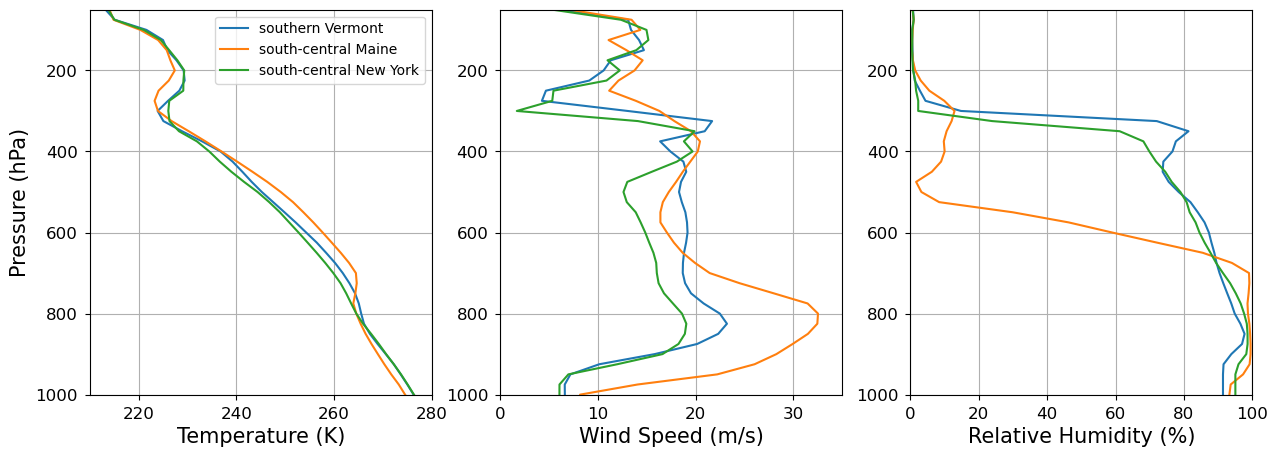

In [10]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

for i, ax in enumerate(axes.flat):
    
    # Plot profiles
    axes[0].plot(t_profs[i, :], pres_levs,  label = data.location[i])
    axes[1].plot(spd_profs[i, :], pres_levs)
    axes[2].plot(rh_profs[i, :], pres_levs)
    
    # Plot appearance
    ax.set_ylim(1000, 50)
    ax.grid()
    ax.tick_params(axis = 'both', labelsize = 12, pad = 5)
    
# Individual plot appearances
axes[0].set_xlim(210, 280)
axes[0].set_ylabel('Pressure (hPa)', fontsize = 15)
axes[0].set_xlabel('Temperature (K)', fontsize = 15)
axes[0].legend()

axes[1].set_xlim(0, 35)
axes[1].set_xlabel('Wind Speed (m/s)', fontsize = 15)

axes[2].set_xlim(0, 100)
axes[2].set_xlabel('Relative Humidity (%)', fontsize = 15)

In [11]:
# To predict SLR, the profiles need to converted
# from pressure levels to levels above ground (i.e.,
# the HRRR's surface elevation. So we use the HRRR's
# geopotential height profiles
gh_profs = hrrr_funcs.extract_profile(
    'gh',
    selected_grid_points,
    init_time,
    fhr,
    ds = ds
)
# Geopotential height profiles
gh_profs = np.array(
    [prof[0].values.squeeze() for prof in gh_profs]
)

# Convert from pressure levels to AGL 

In [12]:
# Levels used by RF (300, 600, 900, 1200, 1500, 1800, 2100, and 2400 m AGL)
agl_levs = list(np.arange(300, 2400 + 1, 300))

# Key formatting for each variable
atmos_vars = ['T', 'SPD', 'R']
vars_levs = [
    '03K',
    '06K',
    '09K', 
    '12K', 
    '15K',
    '18K',
    '21K',
    '24K',
]

# Create dictionary for adding variables to pd.DataFrame
var_dict = {f"{var}{lev}": np.zeros(len(data)) for var in atmos_vars for lev in vars_levs}

# Loop through each HRRR grid point
for i, elev in enumerate(hrrr_elevs):
    try:
        for agl_lev, var_lev in zip(agl_levs, vars_levs):
            
            # Find distance from the grid point elevation plus the AGL
            # level to each geopotential height in pressure coordinates
            hgt_diff = abs((elev + agl_lev) - gh_profs[i])
            
            # Lower level
            z1 = int(np.argsort(hgt_diff)[0]) if np.argsort(hgt_diff)[0] < np.argsort(hgt_diff)[1] else int(np.argsort(hgt_diff)[1])
            
            # Upper level
            z2 = int(np.argsort(hgt_diff)[1]) if np.argsort(hgt_diff)[0] < np.argsort(hgt_diff)[1] else int(np.argsort(hgt_diff)[0])
            
            # Find difference between levels for each variable
            dt, dspd, drh = t_profs[i][z1] - t_profs[i][z2], spd_profs[i][z1] - spd_profs[i][z2], rh_profs[i][z1] - rh_profs[i][z2]
            hgt_frac = hgt_diff[z2] / (gh_profs[i][z2] - gh_profs[i][z1])
            
            # Interpolate
            var = 'T%s' % (var_lev)
            if var in var_dict:
                var_dict[var][i] = t_profs[i][z2] + (dt * hgt_frac)
            var = 'SPD%s' % (var_lev)
            if var in var_dict:
                var_dict[var][i] = spd_profs[i][z2] + (dspd * hgt_frac)
            var = 'R%s' % (var_lev)
            if var in var_dict:
                var_dict[var][i] = rh_profs[i][z2] + (drh * hgt_frac)
    except Exception as e:
        print(e)

# Add data into pd.DataFrame
for var, array in var_dict.items():
    data[var] = array

In [13]:
data

,elev,lat,lon,qpf,location,orig_lat,orig_lon,T03K,T06K,T09K,...,SPD21K,SPD24K,R03K,R06K,R09K,R12K,R15K,R18K,R21K,R24K
0,656.138367,43.035981,-72.932876,1.709,southern Vermont,43.042510,-72.942200,269.540894,267.409149,265.988831,...,18.706964,18.711662,95.804848,97.680176,96.116943,94.365707,93.047775,91.706367,90.469971,89.537109
1,87.607140,44.598069,-69.345951,2.135,south-central Maine,44.586555,-69.351196,271.631683,269.685608,267.893677,...,28.514769,24.510628,97.378113,99.321404,99.478012,99.310661,98.950203,98.625191,98.852310,99.120934
2,617.575867,42.457156,-74.392366,2.339,south-central New York,42.458632,-74.409330,270.209564,268.168243,266.061279,...,16.093472,15.989123,98.335571,98.596489,98.392700,97.410835,96.031326,94.232162,92.054115,89.831131


# We can now predict snow-to-liquid ratio at each point 
# using the random forest

In [14]:
modeldir = '../models/rf/'
slr_model = np.load(
    modeldir + 'rf_slr_model.pkl', 
    allow_pickle = True
)
slr_model_keys = np.load(
    modeldir + 'rf_slr_model_keys.npy',
    allow_pickle = True
)

model_keys_data = data.loc[:, slr_model_keys]
data['rf_slr'] = slr_model.predict(model_keys_data)
data['rf_qsf'] = data.rf_slr * data.qpf
data.rf_slr

0    10.593497
1    10.664233
2    11.721898
Name: rf_slr, dtype: float64

# Let's predict SLR across the HRRR's entire grid!

In [15]:
# Calculate AGl temperature, wind speed, and relative humidity
t_agl, spd_agl, r_agl = slr_grid_funcs.calc_gridded_agl_vars(ds, agl_levs)
rf_features = {
    'T' : t_agl,
    'SPD' : spd_agl,
    'R' : r_agl,
    'lat' : ds.latitude,
    'lon' : ds.longitude,
    'elev' : ds.orog,
}

# Predict SLR

In [16]:
gridded_rf_slr = slr_grid_funcs.calc_slr(rf_features, slr_model, slr_model_keys)

# Add SLR and RF-derived QSF to the xr.Dataset()

In [17]:
ds['rf_slr'] = xr.DataArray(
    gridded_rf_slr.reshape(ds.latitude.shape),
    dims = ('y', 'x')
)
ds['rf_qsf'] = ds.tp * ds.rf_slr

# Plot SLR and QSF

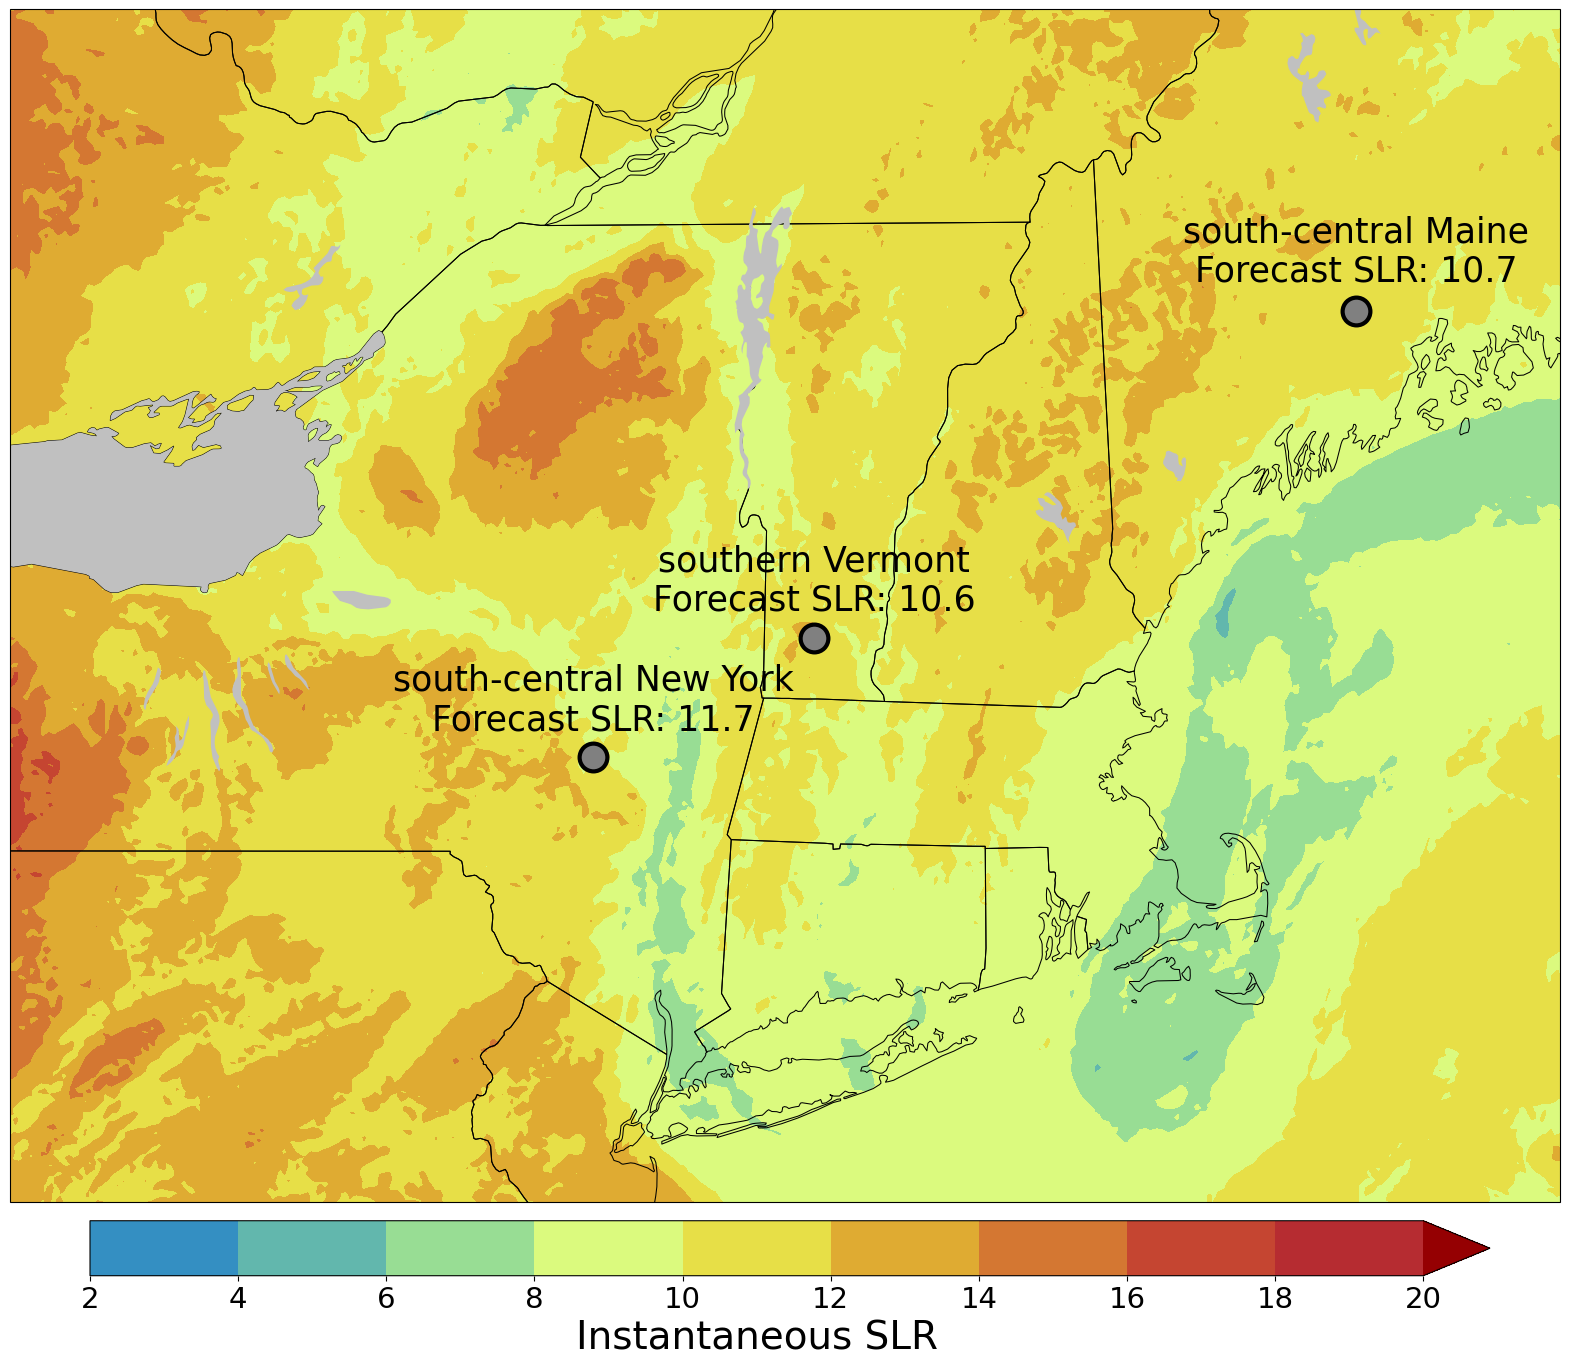

In [18]:
# Create figure
fig, ax = maps.conus_map(topo_overlay = False)

# Select plot variables based on the region
region = 'NE_CASE'
cb_x, cb_y = CB_POS[region]
map_bounds = MAP_REGIONS[region]
    
# Set axis extent based on region
ax.set_extent(map_bounds)

# Plot using colored contours
ct = ax.contourf(
    ds.longitude,
    ds.latitude,
    ds.rf_slr,
    transform = ccrs.PlateCarree(),
    levels = SLR_INTV_LEVS,
    zorder = 1,
    colors = SLR_FILL_COLORS,
    extend = 'max'
)

# Add colorbar
cbar_ax = fig.add_axes([cb_x, cb_y, 0.7, 0.0275])
cb = fig.colorbar(
    ct, 
    cax = cbar_ax, 
    fraction = 0.046, 
    pad = 0.04, 
    orientation = 'horizontal', 
    extend = 'max',
)
cb.set_label('Instantaneous SLR', size = 28)
cb.ax.tick_params(labelsize = 21)

for _, grid_point in data.iterrows():
    
    ax.scatter(
        grid_point.lon,
        grid_point.lat,
        c = 'gray',
        transform = ccrs.PlateCarree(),
        zorder = 5,
        edgecolor = 'k',
        s = 400,
        linewidth = 3
    )
    ax.text(
        grid_point.lon,
        grid_point.lat + 0.28,
        str(grid_point.location) + '\nForecast SLR: ' + str(np.round(grid_point.rf_slr, 1)),
        fontsize = 25,
        color = 'k',
        transform = ccrs.PlateCarree(),
        ha = 'center',
        va = 'center',
        zorder = 11
    )

# Plot SLR only where there's precipitation

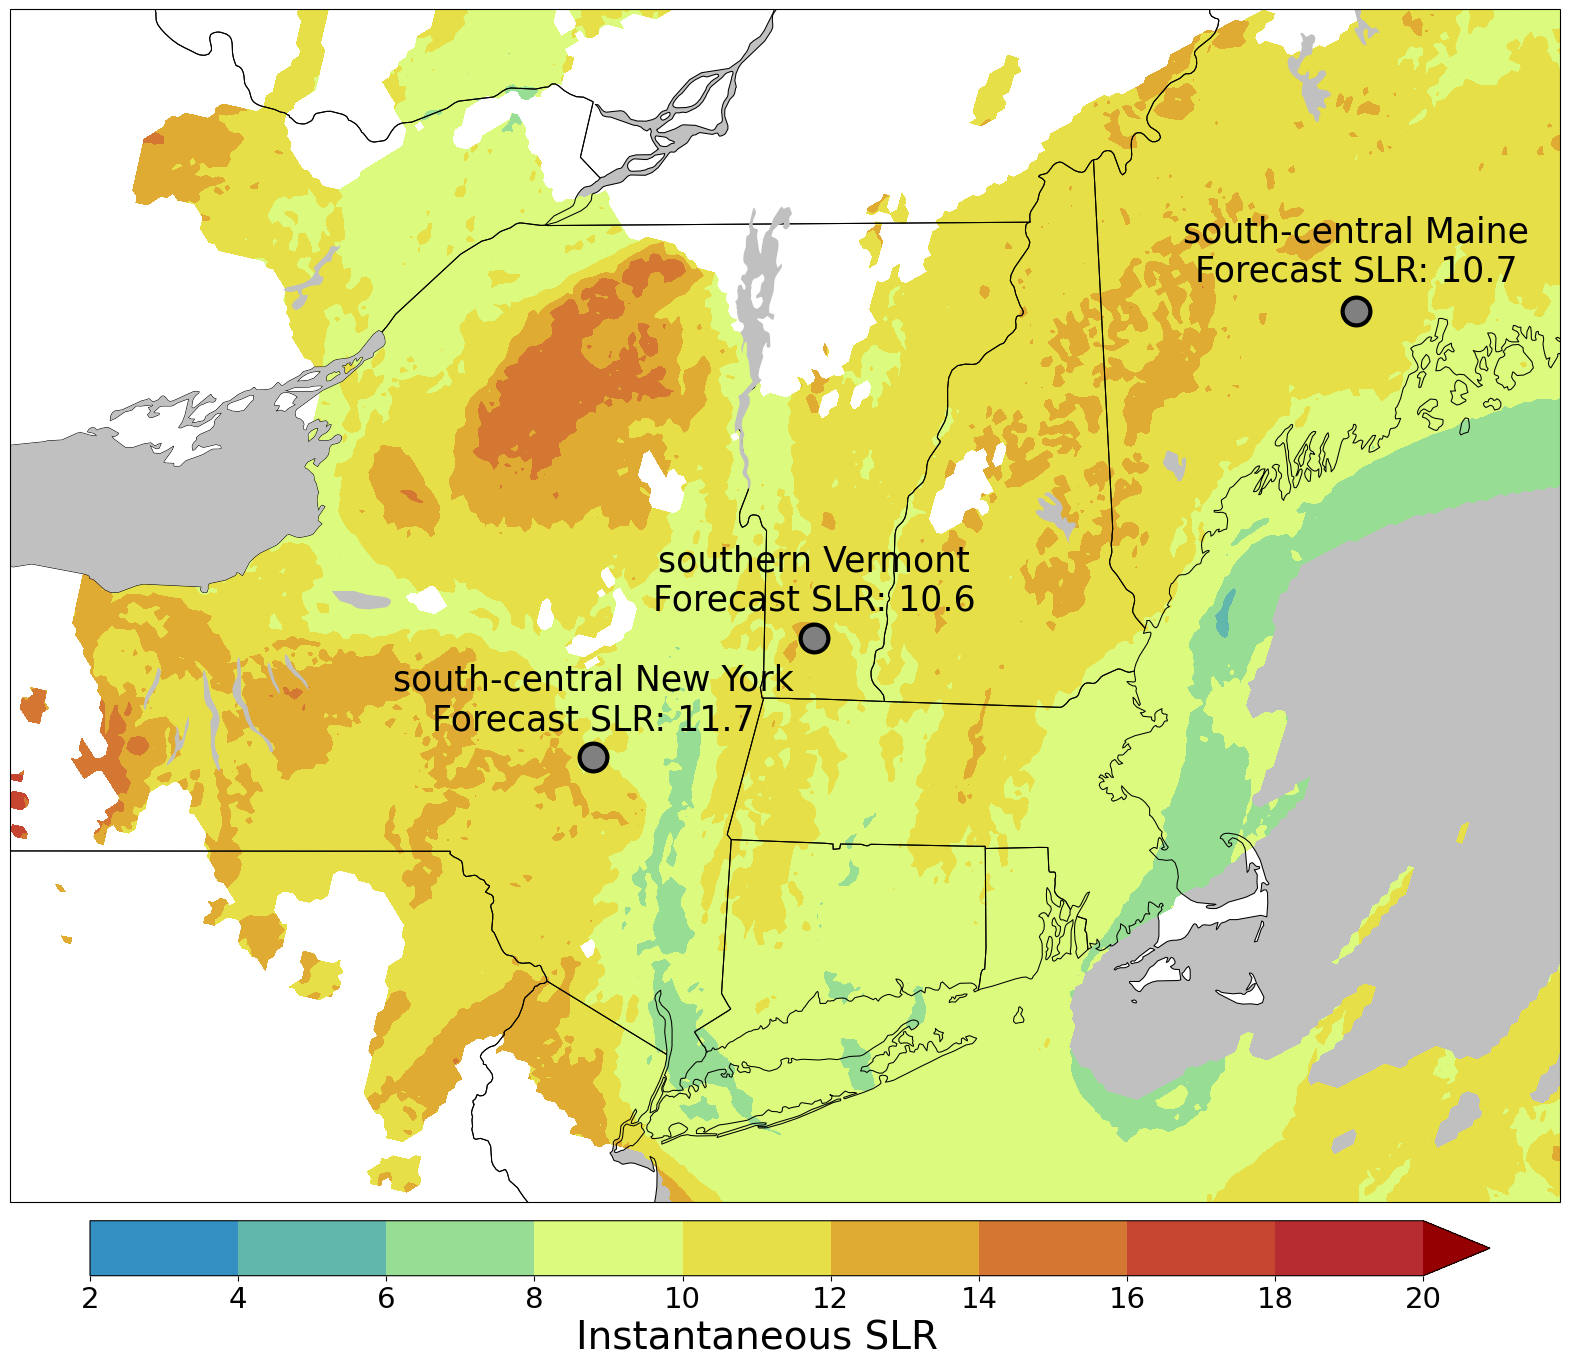

In [19]:
# Create figure
fig, ax = maps.conus_map(topo_overlay = False)

# Select plot variables based on the region
region = 'NE_CASE'
cb_x, cb_y = CB_POS[region]
map_bounds = MAP_REGIONS[region]
    
# Set axis extent based on region
ax.set_extent(map_bounds)

# Plot using colored contours
ct = ax.contourf(
    np.where(ds.tp >= 0.1, ds.longitude, np.nan),
    np.where(ds.tp >= 0.1, ds.latitude, np.nan),
    np.where(ds.tp >= 0.1, ds.rf_slr, np.nan),
    transform = ccrs.PlateCarree(),
    levels = SLR_INTV_LEVS,
    zorder = 1,
    colors = SLR_FILL_COLORS,
    extend = 'max'
)

# Colorbar
cbar_ax = fig.add_axes([cb_x, cb_y, 0.7, 0.0275])
cb = fig.colorbar(
    ct, 
    cax = cbar_ax, 
    fraction = 0.046, 
    pad = 0.04, 
    orientation = 'horizontal', 
    extend = 'max',
)
cb.set_label('Instantaneous SLR', size = 28)
cb.ax.tick_params(labelsize = 21)

for _, grid_point in data.iterrows():
    
    ax.scatter(
        grid_point.lon,
        grid_point.lat,
        c = 'gray',
        transform = ccrs.PlateCarree(),
        zorder = 5,
        edgecolor = 'k',
        s = 400,
        linewidth = 3
    )
    ax.text(
        grid_point.lon,
        grid_point.lat + 0.28,
        str(grid_point.location) + '\nForecast SLR: ' + str(np.round(grid_point.rf_slr, 1)),
        fontsize = 25,
        color = 'k',
        transform = ccrs.PlateCarree(),
        ha = 'center',
        va = 'center',
        zorder = 11
    )

# Plot QSF

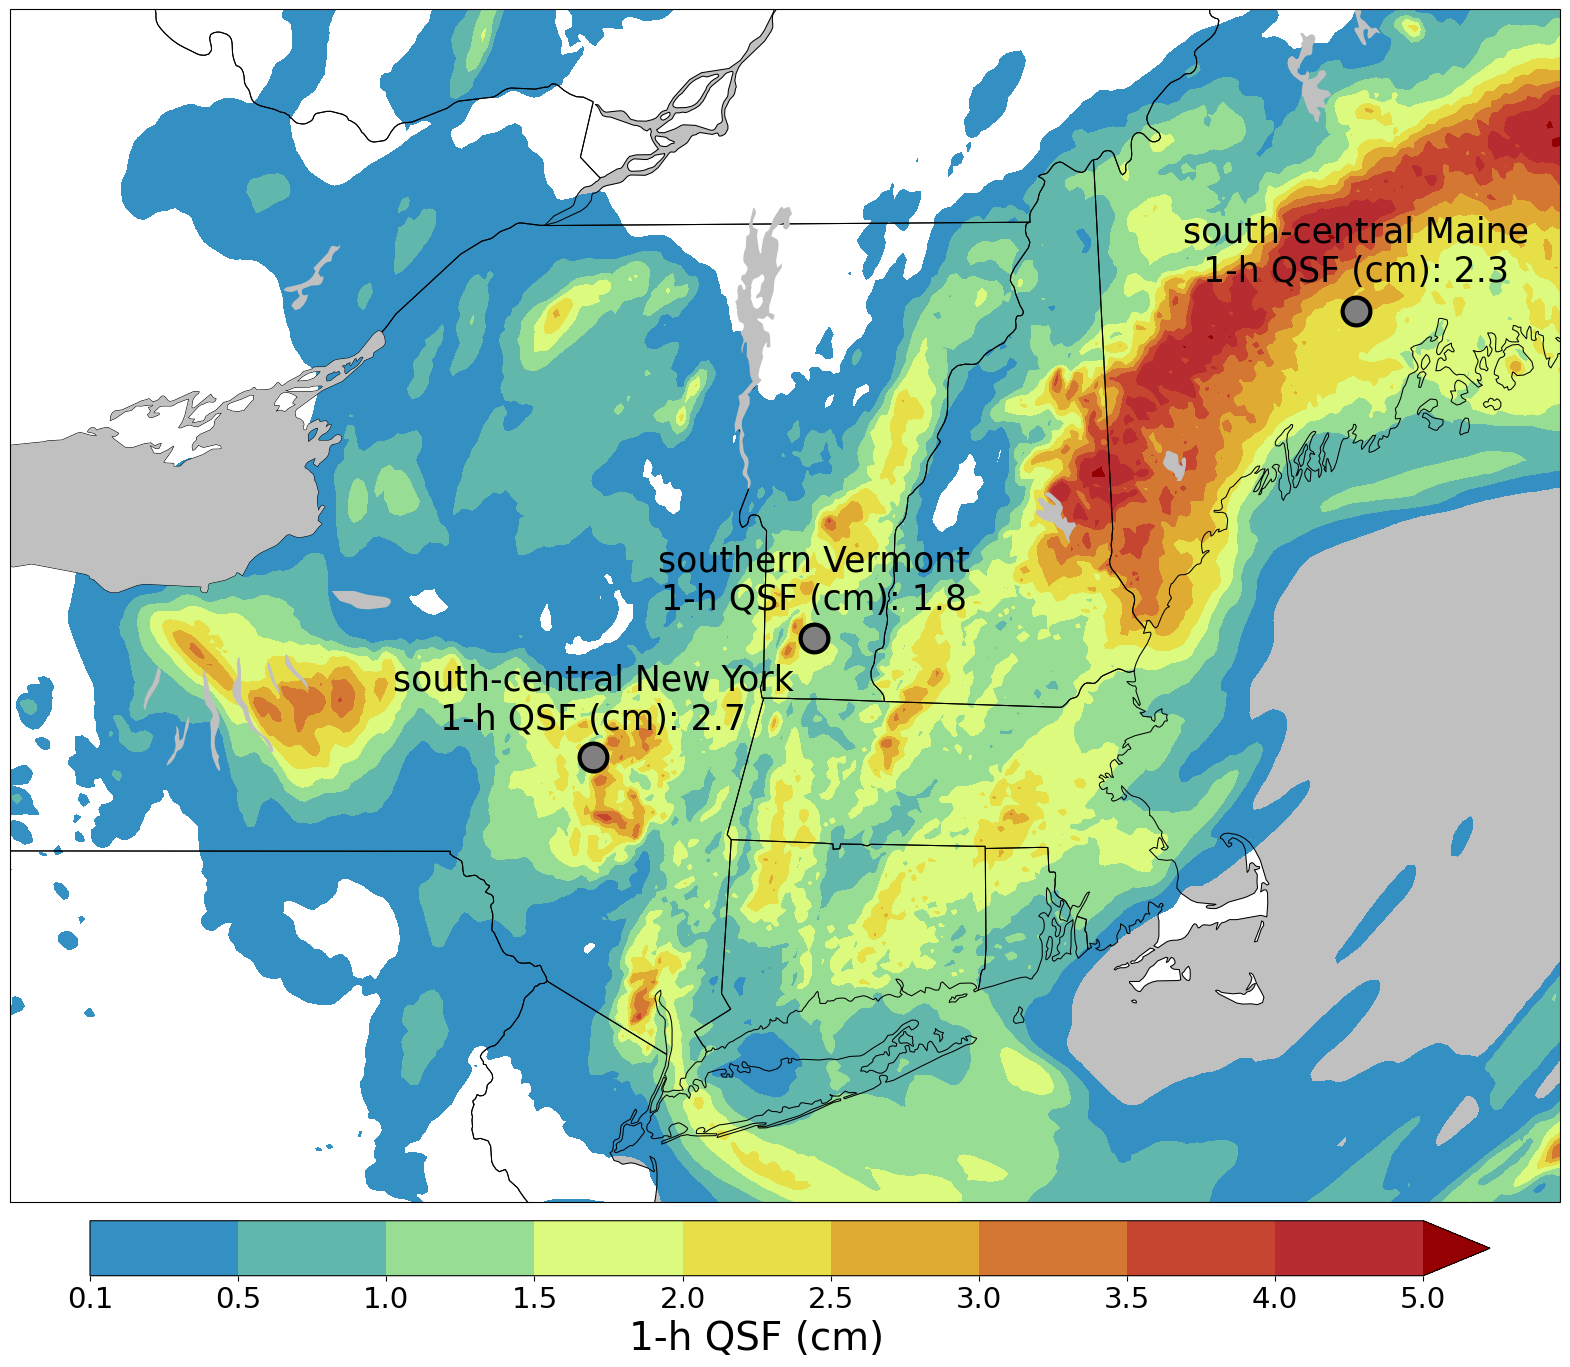

In [20]:
# Create figure
fig, ax = maps.conus_map(topo_overlay = False)

# Select plot variables based on the region
region = 'NE_CASE'
cb_x, cb_y = CB_POS[region]
map_bounds = MAP_REGIONS[region]
    
# Set axis extent based on region
ax.set_extent(map_bounds)

# Plot using colored contours
ct = ax.contourf(
    ds.longitude,
    ds.latitude,
    ds.rf_qsf / 10, # Convert from mm to cm
    transform = ccrs.PlateCarree(),
    levels = SNOW_INTV_LEVS_CM_1H,
    zorder = 1,
    colors = SLR_FILL_COLORS,
    extend = 'max'
)

# Colorbar
cbar_ax = fig.add_axes([cb_x, cb_y, 0.7, 0.0275])
cb = fig.colorbar(
    ct, 
    cax = cbar_ax, 
    fraction = 0.046, 
    pad = 0.04, 
    orientation = 'horizontal', 
    extend = 'max',
)
cb.set_label('1-h QSF (cm)', size = 28)
cb.ax.tick_params(labelsize = 21)

for _, grid_point in data.iterrows():
    
    ax.scatter(
        grid_point.lon,
        grid_point.lat,
        c = 'gray',
        transform = ccrs.PlateCarree(),
        zorder = 5,
        edgecolor = 'k',
        s = 400,
        linewidth = 3
    )
    ax.text(
        grid_point.lon,
        grid_point.lat + 0.28,
        str(grid_point.location) + '\n1-h QSF (cm): ' + str(np.round(grid_point.rf_qsf / 10, 1)),
        fontsize = 25,
        color = 'k',
        transform = ccrs.PlateCarree(),
        ha = 'center',
        va = 'center',
        zorder = 11
    )